# Solve Any Data Analysis Problem

## Chapter 13 - Project 8 Part 2 - example solution

Original data from: https://github.com/aliannejadi/LSApp

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

users = pd.read_parquet("./data/users.parquet")
users.head()

,user_id,time_night_owl,time_early_morning_browser,time_midday_browser,time_late_day_browser,app_category_Browsing,app_category_Entertainment,app_category_Money,app_category_Social,app_category_Utility,number_of_apps,number_of_sessions,avg_session_length
0,0,1,0,0,1,0,1,0,0,0,19,238,0.658333
1,1,0,0,0,1,0,0,0,1,0,18,88,1.483333
2,2,0,1,0,0,0,0,0,1,0,16,61,0.533333
3,3,0,0,0,1,0,0,1,0,0,15,70,0.116667
4,4,1,0,0,0,0,0,0,1,0,8,45,0.233333


# Clustering

Before we segment our users, we need to *standardize* the data. This means putting each column on the same scale.

Why? Because otherwise the groups will reflect variance in the categories with the biggest spread of values.

We have "number of sessions" in the thousands and a lot of binary variables. If we're measuring distance between points, only distances along the "number of sessions" axis will be counted, since the distance in the binary variables will never be more than 1.

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = users.drop(columns=["user_id"])

continuous_features = ['number_of_apps',
                       'number_of_sessions',
                       'avg_session_length']

X_scaled = X.copy()
X_scaled.loc[:,continuous_features] = scaler.fit_transform(X[continuous_features])

X_scaled.head().transpose()

,0,1,2,3,4
time_night_owl,1.000000,0.000000,0.000000,0.000000,1.000000
time_early_morning_browser,0.000000,0.000000,1.000000,0.000000,0.000000
time_midday_browser,0.000000,0.000000,0.000000,0.000000,0.000000
time_late_day_browser,1.000000,1.000000,0.000000,1.000000,0.000000
app_category_Browsing,0.000000,0.000000,0.000000,0.000000,0.000000
app_category_Entertainment,1.000000,0.000000,0.000000,0.000000,0.000000
app_category_Money,0.000000,0.000000,0.000000,1.000000,0.000000
app_category_Social,0.000000,1.000000,1.000000,0.000000,1.000000
app_category_Utility,0.000000,0.000000,0.000000,0.000000,0.000000
number_of_apps,0.442882,0.286854,-0.025200,-0.181228,-1.273419


Import a clustering algorithm

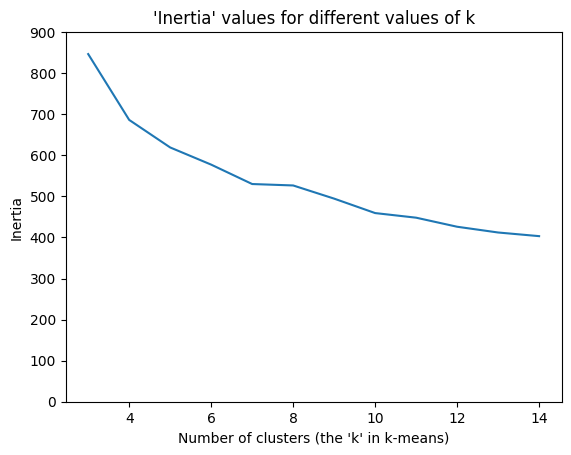

In [3]:
from sklearn.cluster import KMeans

k_values = range(3, 15)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

fig, axis = plt.subplots()

axis.plot(k_values, inertia_values)

_ = axis.set(
    title="'Inertia' values for different values of k",
    xlabel="Number of clusters (the 'k' in k-means)",
    ylabel="Inertia"
)

axis.set_ybound(0, 900)

plt.show()

Looks like the gain in "closeness" of clusters levels out at 7, so let's try 7 groups.

In [4]:
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
users["cluster"] = clusters

users.head().transpose()

,0,1,2,3,4
user_id,0.000000,1.000000,2.000000,3.000000,4.000000
time_night_owl,1.000000,0.000000,0.000000,0.000000,1.000000
time_early_morning_browser,0.000000,0.000000,1.000000,0.000000,0.000000
time_midday_browser,0.000000,0.000000,0.000000,0.000000,0.000000
time_late_day_browser,1.000000,1.000000,0.000000,1.000000,0.000000
app_category_Browsing,0.000000,0.000000,0.000000,0.000000,0.000000
app_category_Entertainment,1.000000,0.000000,0.000000,0.000000,0.000000
app_category_Money,0.000000,0.000000,0.000000,1.000000,0.000000
app_category_Social,0.000000,1.000000,1.000000,0.000000,1.000000
app_category_Utility,0.000000,0.000000,0.000000,0.000000,0.000000


## Evaluation

First of all, how many in each group?

In [5]:
users["cluster"].value_counts().sort_index()

0    42
1    31
2    60
3    78
4     3
5     2
6    75
Name: cluster, dtype: int64

What are the characteristics of each group?

In [6]:
import numpy as np

original_cluster_centers = np.copy(kmeans.cluster_centers_)

cluster_centers = pd.DataFrame(
    data=original_cluster_centers,
    columns=X_scaled.columns
)

cluster_centers.loc[:,continuous_features] = scaler.inverse_transform(original_cluster_centers[:,-3:])

cluster_centers.transpose().round(2)

,0,1,2,3,4,5,6
time_night_owl,0.48,0.45,0.33,1.00,0.00,0.00,0.00
time_early_morning_browser,0.24,0.06,0.17,0.05,0.00,0.00,0.19
time_midday_browser,0.17,0.03,0.32,0.04,0.67,0.00,0.36
time_late_day_browser,0.36,0.48,0.53,0.22,0.33,1.00,0.60
app_category_Browsing,0.10,0.00,0.43,0.05,0.00,0.00,0.05
app_category_Entertainment,0.05,-0.00,0.13,0.05,0.00,0.00,0.03
app_category_Money,0.05,0.00,-0.00,0.05,0.00,0.00,0.08
app_category_Social,0.76,0.97,0.28,0.79,1.00,1.00,0.83
app_category_Utility,0.05,0.03,0.15,0.05,0.00,0.00,0.01
number_of_apps,15.64,24.35,7.18,18.18,27.33,19.50,17.61


Quite a lot to find here! This describes the "average" user within each group, like a persona.

Some general observations:

- It looks like groups 4 and 5 are the outlier groups in terms of number of sessions and average session length respectively.
- Group 1 are heavy users, mostly for social media and late in the day or at night
- Group 2 are infrequent users, mostly use their phone for browsing and generally short sessions

Personas would be statements like "users in cluster 1 tend to have a lot of user sessions, a lot of apps, and primarily use their phone for social media apps after work hours".